# Pay Band Design & Pay Compression Risk Analysis

### Objective
This project evaluates internal compensation structure using payroll data to:
- Design role-based pay bands
- Identify pay compression and inversion risks
- Assess departmental exposure
- Estimate the financial impact of correcting pay misalignment

The analysis focuses on internal equity and compensation governance.


## Business Context

Pay compression occurs when salary differences between roles narrow, increasing retention risk, morale issues, and governance exposure.

This study addresses:
- Are salaries aligned with structured pay bands?
- Where does pay compression exist?
- Which departments are most exposed?

Import Libraries & Load Data

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)

In [21]:
from google.colab import files
uploaded = files.upload()

import pandas as pd

df = pd.read_csv(list(uploaded.keys())[0])
df.head()

Saving salary.csv.zip to salary.csv (1).zip


,Name,Job Titles,Department,Full or Part-Time,Salary or Hourly,Typical Hours,Annual Salary,Hourly Rate
0,"AARON, JEFFERY M",SERGEANT,POLICE,F,Salary,NaN,122568.0,NaN
1,"AARON, KARINA",POLICE OFFICER (ASSIGNED AS DETECTIVE),POLICE,F,Salary,NaN,110796.0,NaN
2,"ABAD JR, VICENTE M",CIVIL ENGINEER IV,WATER MGMNT,F,Salary,NaN,122112.0,NaN
3,"ABARCA, EMMANUEL",CONCRETE LABORER,TRANSPORTN,F,Hourly,40.0,NaN,45.9
4,"ABARCA, FRANCES J",POLICE OFFICER,POLICE,F,Salary,NaN,86730.0,NaN


Data Cleaning & Standardization

In [22]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

Annualize Compensation

In [23]:
df["annualized_salary"] = np.where(
    df["salary_or_hourly"].str.lower() == "hourly",
    df["hourly_rate"] * df["typical_hours"] * 52,
    df["annual_salary"]
)

In [24]:
df = df[df["annualized_salary"].notna()]

Job Title Normalization

In [25]:
df["job_title_clean"] = df["job_titles"].str.upper().str.strip()

## Job Family Engineering

Raw job titles are highly granular and inconsistent.  
Roles are grouped into standardized job families to enable meaningful compensation analysis and executive-level reporting.


In [26]:
def job_family(title):
    title = title.upper()

    if "POLICE" in title:
        return "Police"
    elif "FIRE" in title:
        return "Fire"
    elif "ENGINEER" in title:
        return "Engineering"
    elif "MANAGER" in title or "DIRECTOR" in title:
        return "Management"
    elif "ADMIN" in title or "ASSIST" in title or "CLERK" in title:
        return "Administration"
    elif "MECHANIC" in title or "TECH" in title:
        return "Technical"
    else:
        return "Other"

df["job_family"] = df["job_title_clean"].apply(job_family)

## Pay Band Design

Pay bands are constructed using internal salary percentiles for each job family.


In [28]:
pay_bands = (
    df.groupby("job_family")["annualized_salary"]
    .quantile([0.25, 0.50, 0.75])
    .unstack()
)

pay_bands.columns = ["p25", "median", "p75"]
pay_bands.reset_index(inplace=True)

In [29]:
df = df.merge(pay_bands, on="job_family", how="left")

## Compa-Ratio Calculation

Compa-ratio measures how an employee's salary compares to the midpoint of their pay band.


In [42]:
df["compa_ratio"] = df["annualized_salary"] / df["median"]
df[["job_family", "annualized_salary", "median", "compa_ratio"]].head()

,job_family,annualized_salary,median,compa_ratio
0,Other,122568.0,91944.0,1.333072
1,Police,110796.0,98940.0,1.119830
2,Engineering,122112.0,111488.0,1.095293
3,Other,95472.0,91944.0,1.038371
4,Police,86730.0,98940.0,0.876592


## Pay Compression Identification

Employees earning above the P75 threshold are flagged as potential pay compression or inversion cases.

In [43]:
df["compression_flag"] = np.where(
    df["annualized_salary"] > df["p75"],
    "High Risk",
    "Normal"
)

df["compression_flag"].value_counts()

,count
compression_flag,
Normal,24017
High Risk,7084


## Salary Distribution by Job Family

This visualization highlights pay dispersion and compression risk across job families.

In [32]:
family_counts = df["job_family"].value_counts()
major_families = family_counts[family_counts > 50].index
df_plot = df[df["job_family"].isin(major_families)]

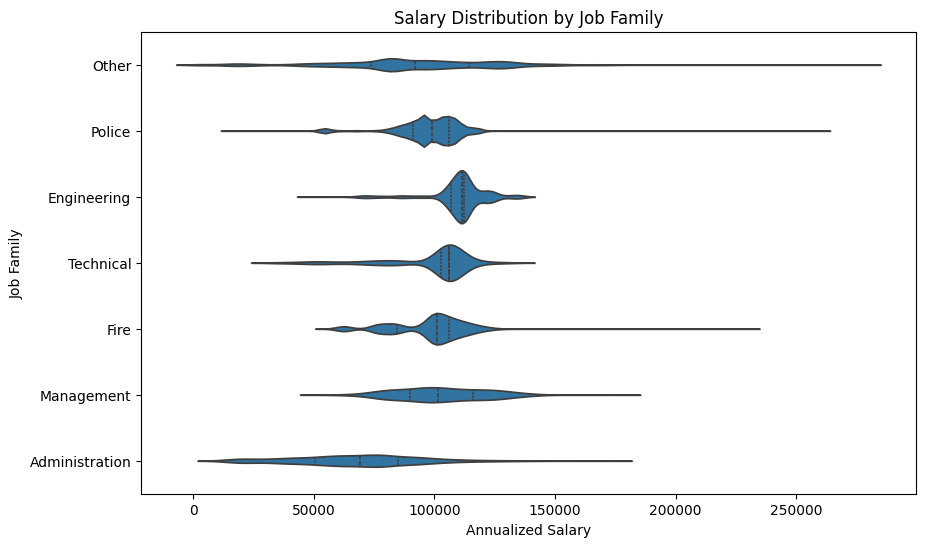

In [45]:
plt.figure(figsize=(10,6))
sns.violinplot(
    data=df_plot,
    x="annualized_salary",
    y="job_family",
    inner="quartile"
)
plt.title("Salary Distribution by Job Family")
plt.xlabel("Annualized Salary")
plt.ylabel("Job Family")
plt.show()

## Compa-Ratio Distribution

This chart shows how employees are positioned relative to their pay band midpoint.

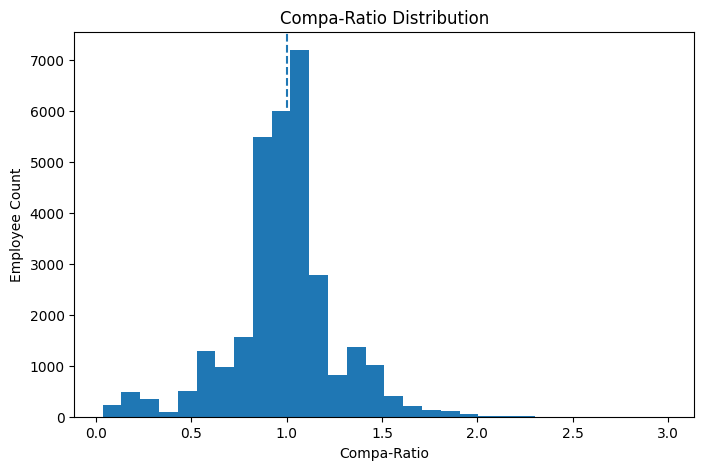

In [46]:
plt.figure(figsize=(8,5))
plt.hist(df["compa_ratio"], bins=30)
plt.axvline(1, linestyle="--")
plt.title("Compa-Ratio Distribution")
plt.xlabel("Compa-Ratio")
plt.ylabel("Employee Count")
plt.show()

## Pay Band Structure by Job Family

This visualization illustrates the P25–Median–P75 pay range for each job family.

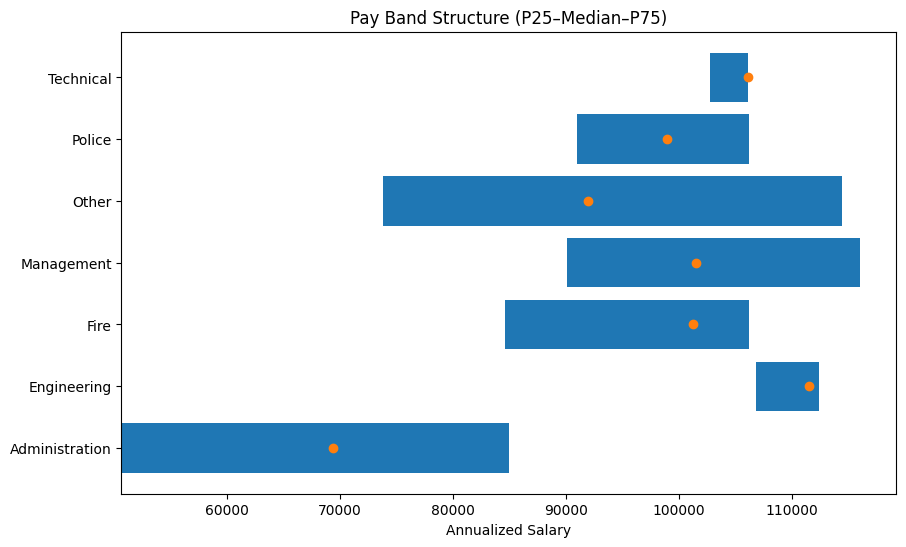

In [47]:
plt.figure(figsize=(10,6))

plt.barh(
    pay_bands["job_family"],
    pay_bands["p75"] - pay_bands["p25"],
    left=pay_bands["p25"]
)

plt.scatter(pay_bands["median"], pay_bands["job_family"])
plt.xlabel("Annualized Salary")
plt.title("Pay Band Structure (P25–Median–P75)")
plt.show()

## Department-Level Pay Compression Summary

This table summarizes compression exposure across departments.

In [48]:
compression_summary = (
    df.groupby("department")
    .agg(
        avg_salary=("annualized_salary", "mean"),
        compression_cases=("compression_flag", lambda x: (x == "High Risk").sum()),
        total_employees=("compression_flag", "count")
    )
)

compression_summary["compression_rate"] = (
    compression_summary["compression_cases"] /
    compression_summary["total_employees"]
)

compression_summary.sort_values("compression_rate", ascending=False)

,avg_salary,compression_cases,total_employees,compression_rate
department,,,,
POLICE BOARD,89634.000000,1,2,0.500000
BUILDINGS,113061.142241,102,232,0.439655
MAYOR'S OFFICE,102897.151515,41,99,0.414141
BUDGET & MGMT,103342.909091,13,33,0.393939
FIRE,106029.222179,1796,4801,0.374089
PUBLIC SAFETY ADMIN,95077.893333,91,294,0.309524
LAW,99022.390937,102,331,0.308157
POLICE,101387.804256,3653,12537,0.291378
TREASURER,98541.666667,7,27,0.259259


## Compression Risk by Department

Departments are ranked by proportion of employees exceeding pay band limits.

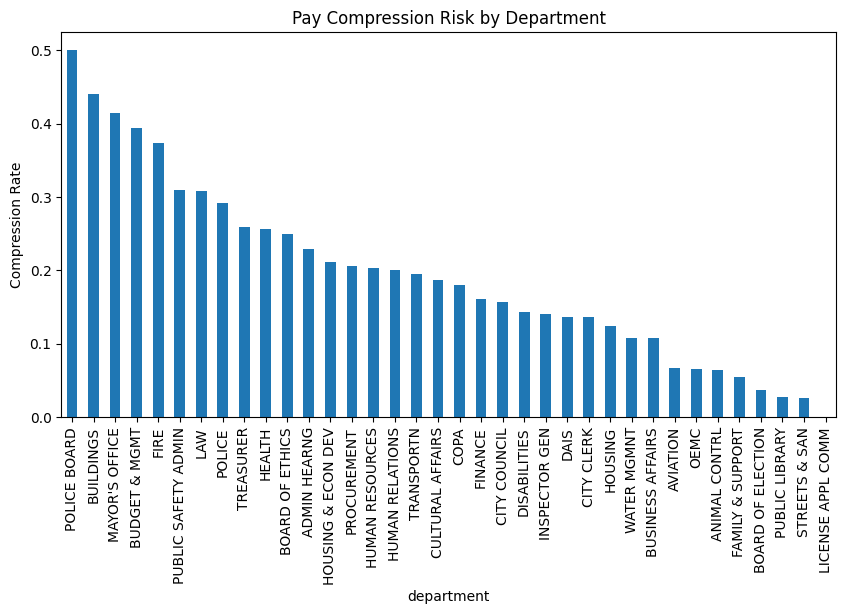

In [49]:
compression_summary.sort_values(
    "compression_rate", ascending=False
)["compression_rate"].plot(kind="bar", figsize=(10,5))

plt.ylabel("Compression Rate")
plt.title("Pay Compression Risk by Department")
plt.show()

## Salary Concentration Analysis

This curve shows how total compensation is concentrated among top earners.

In [50]:
df_sorted = df.sort_values("annualized_salary", ascending=False)

df_sorted["cumulative_salary_share"] = (
    df_sorted["annualized_salary"].cumsum() /
    df_sorted["annualized_salary"].sum()
)

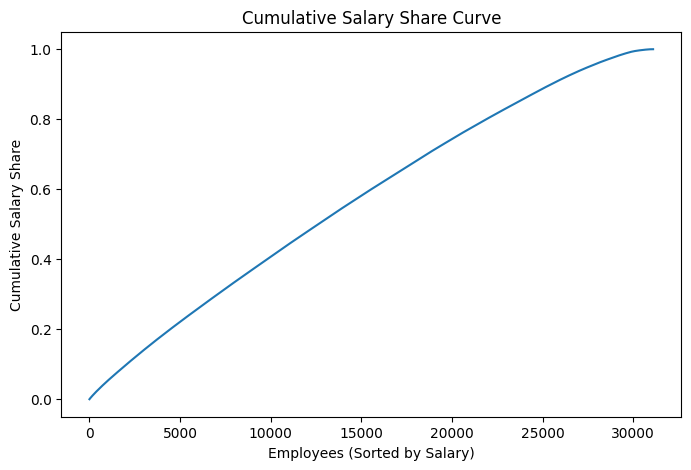

In [51]:
plt.figure(figsize=(8,5))
plt.plot(df_sorted["cumulative_salary_share"].values)
plt.title("Cumulative Salary Share Curve")
plt.xlabel("Employees (Sorted by Salary)")
plt.ylabel("Cumulative Salary Share")
plt.show()

## Financial Impact of Pay Compression

This section estimates the annual cost of salaries exceeding the P75 pay band threshold.

In [52]:
df["excess_cost"] = np.where(
    df["annualized_salary"] > df["p75"],
    df["annualized_salary"] - df["p75"],
    0
)

df["excess_cost"].sum()

np.float64(94299237.72)

## 11. Key Findings & Business Implications

### Key Findings
- A material share of employees earn above their job family P75 benchmark.
- Pay compression risk is concentrated in specific departments.
- Inconsistent compa-ratios suggest weak pay band enforcement.

### Business Implications
- Increased retention and morale risk
- Budget inefficiency
- Need for structured compensation governance

## 12. Limitations & Next Steps

- Analysis relies on internal payroll data without performance or tenure indicators.
- Job family classification is rule-based and may oversimplify roles.

Next steps include incorporating tenure, market benchmarks, and promotion history.